In [1]:
#Thư viện torch dùng để xây dựng & huấn luyện mô hình
!pip install -U torch==2.9.0


In [2]:
#Thư viện transformers để dùng mô hình PhoBERT
!pip install -U transformers accelerate datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.3
    Uninstalling transformers-4.57.3:
      Successfully uninstalled transformers-4.57.3
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [3]:
#Thư viện pandas dùng để đọc và xử lý dữ liệu
#Thư viện scikit-learn dùng để chia train/test & đánh giá
#Thư viện openpyxl dùng để đọ file Excel (.xlsx)
!pip install -U pandas==2.2.2 scikit-learn openpyxl emoji underthesea


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.4/978.4 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [4]:
import pandas as pd
import torch
import numpy as np
import re
import emoji
import unicodedata

from underthesea import word_tokenize

from transformers import TrainingArguments, Trainer

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#AutoTokenizer: tự động tải tokenizer phù hợp với PhoBERT
#AutoModelForSequenceClassification: PhoBERT + tầng phân loại
#train_test_split: chia dữ liệu train/test
#accuracy_score: tính độ chính xác

In [5]:
#Đọc file dữ liệu
df = pd.read_excel("Vietnamese_dataset_Spam_Ham.xlsx")

# Cấu trúc file
# label: spam / ham
# message: nội dung tin nhắn
print(df.head())
print("Số dòng ban đầu:", len(df))

  label                                            message
0  spam  [Cảnh Báo Khẩn] Tài khoản của quý khách đang b...
1   ham           Bạn không nói quá sớm ... bạn đã nói ...
2   ham  Không, tôi không nghĩ anh ấy đến USF, anh ấy s...
3   ham  Ngay cả anh trai tôi cũng không thích nói chuy...
4   ham  Chào buổi sáng! Thứ 2 rồi, bạn nhớ kiểm tra em...
Số dòng ban đầu: 5200


In [6]:
#Làm sạch dữ liệu
def clean_text(text):
    text = str(text)

    # Xóa URL
    text = re.sub(r'http\\S+|www\\S+', '', text)

    # Xóa email
    text = re.sub(r'\\S+@\\S+', '', text)

    # Xóa số điện thoại (VN)
    text = re.sub(r'(\\+84|0)[0-9]{9}', '', text)

    # Xóa mã giao dịch (chuỗi số dài)
    text = re.sub(r'\\b\\d{6,}\\b', '', text)

    # Xóa emoji
    text = emoji.replace_emoji(text, replace='')

    # Xóa ký tự đặc biệt
    text = re.sub(r'[^a-zA-ZÀ-ỹ0-9\\s]', ' ', text)

    # Chuẩn hóa khoảng trắng
    text = re.sub(r'\\s+', ' ', text).strip()

    return text.lower()


In [7]:
# Loại bỏ trùng lặp
df.drop_duplicates(subset="message", inplace=True)

df["clean_message"] = df["message"].apply(clean_text)


In [8]:
#Chuẩn hoá tiếng Việt
def normalize_unicode(text):
    return unicodedata.normalize("NFC", text)

df["clean_message"] = df["clean_message"].apply(normalize_unicode)


In [9]:
# Tách từ
def tokenize_vietnamese(text):
    return word_tokenize(text, format="text")

df["tokenized_message"] = df["clean_message"].apply(tokenize_vietnamese)


In [10]:
print(df.columns)


Index(['label', 'message', 'clean_message', 'tokenized_message'], dtype='object')


In [11]:
"""Loại bỏ Stopword Tiếng Việt
Không cần cho mô hình PhoBERT
vietnamese_stopwords = set([
    "của", "cho", "một", "được", "cứ", "cùng", "cũng", "đều", "do",
    "tôi", "bạn", "chúng", "này", "đó", "đã", "đang", "bị", "các",
    "cả", "cái", "chỉ", "chiếc", "chứ", "mà", "mỗi", "này", "nên",
    "nếu", "ngay", "nhiều", "như", "nhưng", "những", "nữa", "rằng",
    "rất", "rồi", "sau","sẽ", "tại", "theo", "thì", "từng", "và",
    "vẫn", "vậy", "vì", "với"
])
def remove_stopwords(text):
    tokens = text.split()
    tokens = [w for w in tokens if w not in vietnamese_stopwords]
    return " ".join(tokens)

df["final_message"] = df["tokenized_message"].apply(remove_stopwords)
df["final_message"] = df["clean_message"].apply(remove_stopwords)"""


'Loại bỏ Stopword Tiếng Việt\nKhông cần cho mô hình PhoBERT\nvietnamese_stopwords = set([\n    "của", "cho", "một", "được", "cứ", "cùng", "cũng", "đều", "do",\n    "tôi", "bạn", "chúng", "này", "đó", "đã", "đang", "bị", "các",\n    "cả", "cái", "chỉ", "chiếc", "chứ", "mà", "mỗi", "này", "nên",\n    "nếu", "ngay", "nhiều", "như", "nhưng", "những", "nữa", "rằng",\n    "rất", "rồi", "sau","sẽ", "tại", "theo", "thì", "từng", "và",\n    "vẫn", "vậy", "vì", "với"\n])\ndef remove_stopwords(text):\n    tokens = text.split()\n    tokens = [w for w in tokens if w not in vietnamese_stopwords]\n    return " ".join(tokens)\n\ndf["final_message"] = df["tokenized_message"].apply(remove_stopwords)\ndf["final_message"] = df["clean_message"].apply(remove_stopwords)'

In [12]:
#Encode nhãn
label_map = {"ham": 0, "spam": 1}
df["label"] = df["label"].map(label_map)


In [13]:
#Chia tập Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    df["tokenized_message"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


In [14]:
#Vector hoá dữ liệu (Contextual Embedding – PhoBERT)
MODEL_NAME = "vinai/phobert-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
#Tokenize cho PhoBERT
def tokenize_data(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize_data(X_train)
test_encodings = tokenize_data(X_test)


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [16]:
#Dataset cho PyTorch
class SMSDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.values

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [17]:
train_dataset = SMSDataset(train_encodings, y_train)
test_dataset = SMSDataset(test_encodings, y_test)


In [18]:
#Huấn Luyện mô hình PhoBERT
training_args = TrainingArguments(
    output_dir="./phobert_spam",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)


In [19]:
# Đánh giá mô hình
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds)
    }


In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


In [21]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.167428,0.953488
2,No log,0.201776,0.951274
3,0.168200,0.221749,0.945736


TrainOutput(global_step=678, training_loss=0.14943200508050158, metrics={'train_runtime': 427.9018, 'train_samples_per_second': 25.303, 'train_steps_per_second': 1.584, 'total_flos': 712175849095680.0, 'train_loss': 0.14943200508050158, 'epoch': 3.0})

In [22]:
#Đánh giá mô hình
trainer.evaluate()

{'eval_loss': 0.16742762923240662,
 'eval_accuracy': 0.9534883720930233,
 'eval_runtime': 2.9237,
 'eval_samples_per_second': 308.851,
 'eval_steps_per_second': 19.496,
 'epoch': 3.0}

In [23]:
#Predict
preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))


              precision    recall  f1-score   support

         Ham       0.96      0.99      0.97       783
        Spam       0.92      0.71      0.80       120

    accuracy                           0.95       903
   macro avg       0.94      0.85      0.89       903
weighted avg       0.95      0.95      0.95       903



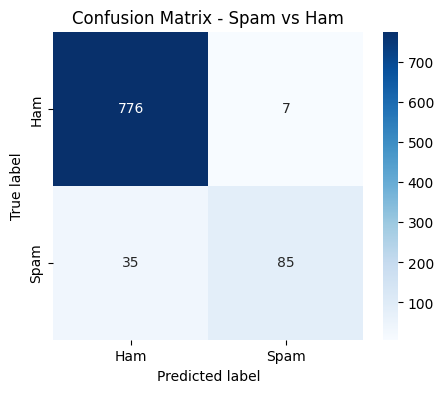

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Ham", "Spam"],
    yticklabels=["Ham", "Spam"]
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Spam vs Ham")
plt.show()


In [25]:
from torch.utils.data import Dataset
#import torch

class SingleTextDataset(Dataset):
    def __init__(self, text, tokenizer):
        self.encodings = tokenizer(
            text,
            truncation=True,
            padding=True,
            max_length=128
        )

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return {k: torch.tensor(v) for k, v in self.encodings.items()}


In [26]:
def predict_sms(text, trainer, tokenizer):
    text = clean_text(text)
    text = normalize_unicode(text)
    text = tokenize_vietnamese(text)
    #text = remove_stopwords(text)

    dataset = SingleTextDataset(text, tokenizer)
    predictions = trainer.predict(dataset)

    pred_label = predictions.predictions.argmax(axis=1)[0]
    return "SPAM" if pred_label == 1 else "HAM"


In [27]:
predict_sms(
    "Nay siêu thị có ưu đãi đấy",
    trainer,
    tokenizer
)


'HAM'

In [28]:
predict_sms(
    "Siêu ưu đãi",
    trainer,
    tokenizer
)

'SPAM'

In [29]:
predict_sms(
    "Siêu ưu đãi, chỉ trong hôm nay",
    trainer,
    tokenizer
)

'SPAM'

In [30]:
predict_sms(
    "Siêu ưu đãi, chỉ có hôm nay thôi, đi mua không mày?",
    trainer,
    tokenizer
)

'HAM'

In [31]:
predict_sms(
    "Thanh toán ngay để nhận được ưu đãi",
    trainer,
    tokenizer
)

'SPAM'

In [32]:
predict_sms(
    "Thanh toán ngay nhé",
    trainer,
    tokenizer
)

'HAM'

In [33]:
#Kiểm tra xem có sử dụng GPU không
import torch
print(torch.cuda.is_available())


True


In [37]:
predict_sms(
    "Hệ thống chính đang bảo trì, lúc nào rảnh bạn vào link phụ bên dưới để làm nha",
    trainer,
    tokenizer
)

'HAM'

In [38]:
predict_sms(
    "Bên mình vừa tổ chức câu lạc bộ đọc sách miễn phí vào tối thứ 5 hằng tuần. Không cần đăng ký gì cả, ai rảnh thì tới ngồi cùng, mang theo sách yêu thích là được. Mình nhắn để mời chứ hoàn toàn không thu phí",
    trainer,
    tokenizer
)

'HAM'

In [52]:
# 1. Đọc file
df_new = pd.read_excel("/content/Test.xlsx")

# 👉 Kiểm tra tên cột thật sự trong file
print("Các cột trong file:", df_new.columns)


# 2. Dự đoán trực tiếp bằng apply
df_new["predict"] = df_new["message"].apply(
    lambda x: predict_sms(x, trainer, tokenizer)
)

# 3. Hiển thị 20 dòng kết quả cạnh nhau
display(df_new)

# 4. Lưu lại nếu cần
df_new.to_excel("sms_test_result.xlsx", index=False)

Các cột trong file: Index(['message', 'actual'], dtype='object')


,message,actual,predict
0,"Chúc mừng bạn đã trúng thưởng 50 triệu, soạn T...",SPAM,SPAM
1,"Hệ thống đang bảo trì, lúc nào rảnh vào làm, b...",SPAM,HAM
2,"Bạn đã được chọn nhận iPhone 15 miễn phí, clic...",SPAM,SPAM
3,Mai bạn nhớ mang tài liệu môn IoT nha,HAM,HAM
4,Khuyến mãi HOT! Nạp thẻ hôm nay nhận ngay 100%...,SPAM,SPAM
...,...,...,...
95,Tối nay mình học online hay nghỉ vậy?,HAM,HAM
96,Xác nhận tHAM gia để giữ chỗ,SPAM,SPAM
97,Anh nhớ phản hồi giúp em trước 5h chiều,HAM,HAM
98,Bên mình đang giảm giá 30% tất cả các mặt hàng...,SPAM,HAM


In [53]:
# Mã hoá nhãn giống lúc train
label_map = {"HAM": 0, "SPAM": 1}

df_new["label_num"] = df_new["actual"].map(label_map)
df_new["predict_num"] = df_new["predict"].map(label_map)


In [54]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

y_true = df_new["label_num"]
y_pred = df_new["predict_num"]

# Accuracy thực tế
acc = accuracy_score(y_true, y_pred)
print("Tỉ lệ chính xác thực tế:", acc)


Tỉ lệ chính xác thực tế: 0.85


In [55]:
cm = confusion_matrix(y_true, y_pred)

TN, FP, FN, TP = cm.ravel()

print("Số tin dự đoán ĐÚNG:", TP + TN)
print("Spam bị bỏ sót (FN):", FN)
print("Ham bị nhầm thành Spam (FP):", FP)
print("Spam dự đoán đúng (TP):", TP)
print("Ham dự đoán đúng (TN):", TN)


Số tin dự đoán ĐÚNG: 85
Spam bị bỏ sót (FN): 7
Ham bị nhầm thành Spam (FP): 8
Spam dự đoán đúng (TP): 32
Ham dự đoán đúng (TN): 53


In [51]:
print(classification_report(y_true, y_pred, target_names=["Ham", "Spam"]))


              precision    recall  f1-score   support

         Ham       0.88      0.87      0.88        61
        Spam       0.79      0.82      0.81        38

    accuracy                           0.85        99
   macro avg       0.84      0.84      0.84        99
weighted avg       0.85      0.85      0.85        99

